## Khai báo thư viện

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

Chúng ta sẽ sử dụng dataset chinook.db 

In [2]:
conn = sqlite3.connect('chinook.db')

In [3]:
# Kiểm tra thông tin các bảng biểu có trong file dữ liệu chinook.db
pd.read_sql('select type, name from sqlite_master where type="table"', conn)

,type,name
0,table,album
1,table,artist
2,table,customer
3,table,employee
4,table,genre
5,table,invoice
6,table,invoice_line
7,table,media_type
8,table,playlist
9,table,playlist_track


## Sơ đồ các bảng dữ liệu có trong dataset
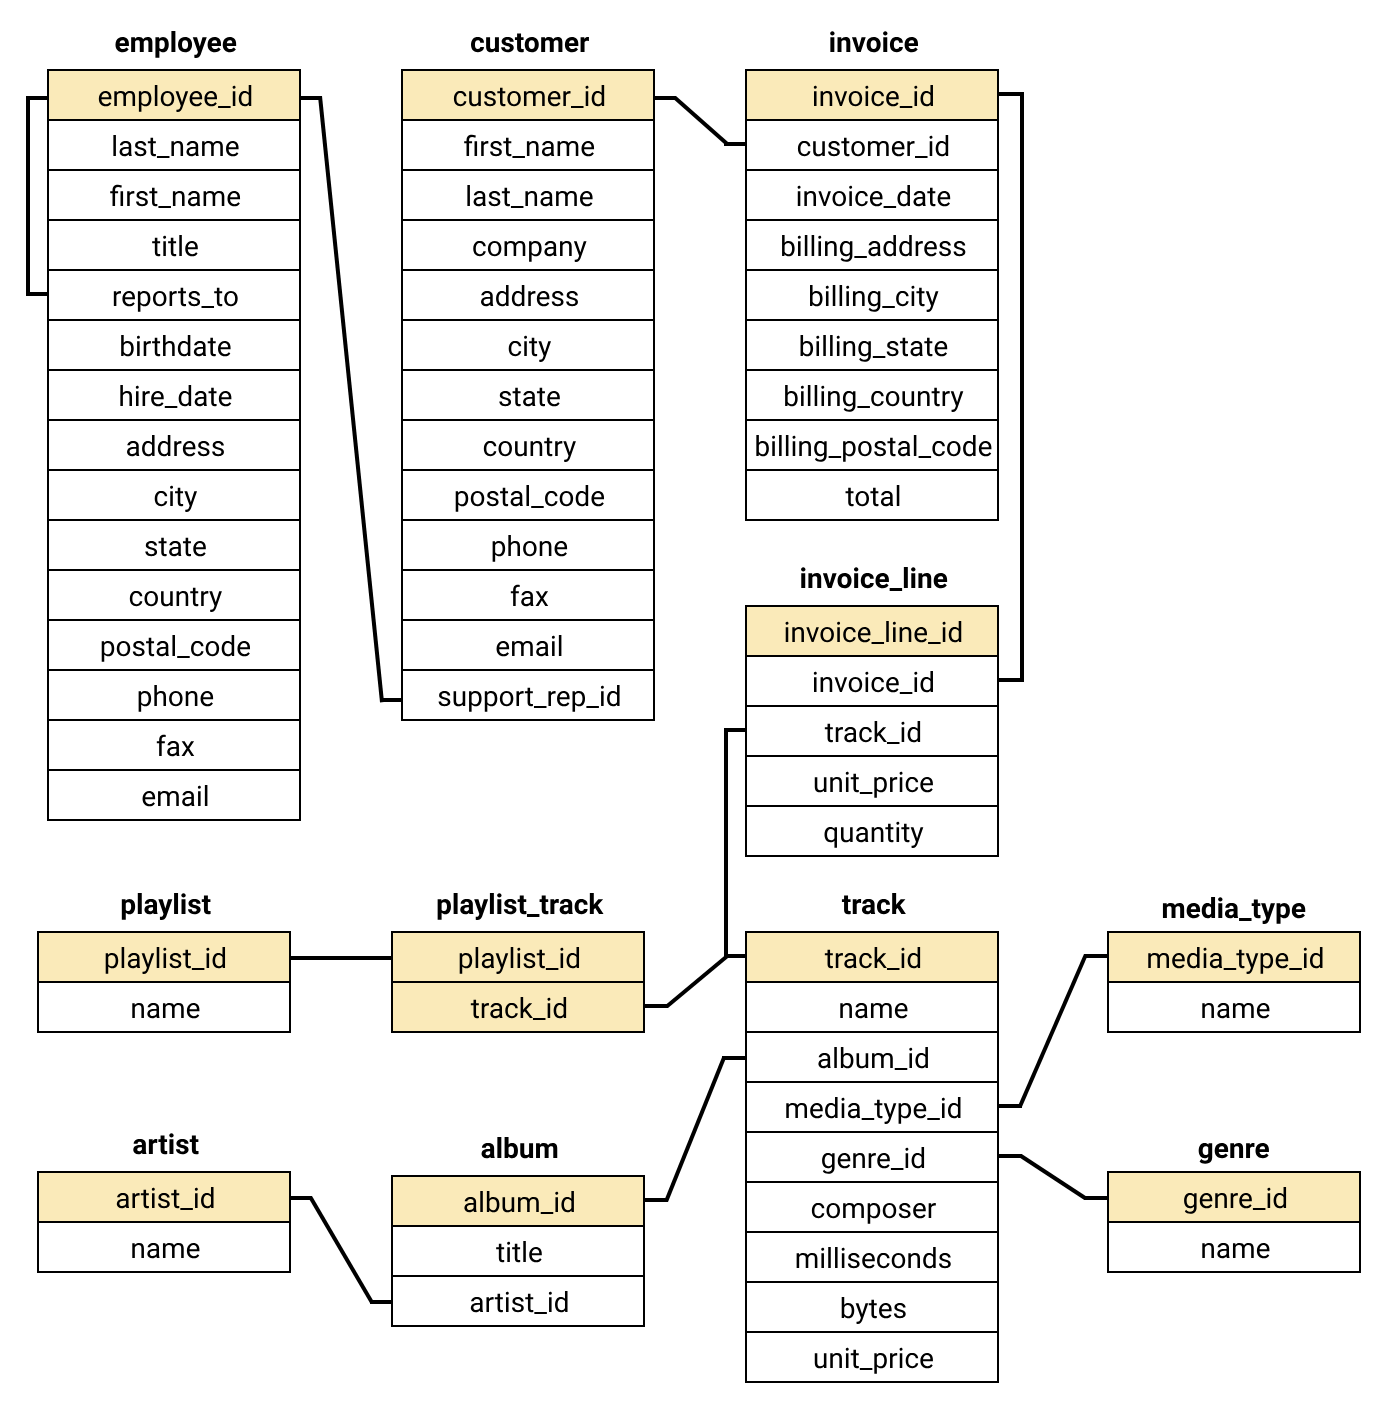

## Câu hỏi 1: Những thể loại nhạc (genre) nào bán chạy nhất ở thị trường Mỹ

In [4]:
best_genre_sold = 'WITH usa_tracks_sold AS\
                       (\
                        SELECT il.* FROM invoice_line il\
                        INNER JOIN invoice i on il.invoice_id = i.invoice_id\
                        INNER JOIN customer c on i.customer_id = c.customer_id\
                        WHERE c.country = "USA"\
                       )\
                        SELECT\
                            g.name NHAC,\
                            count(uts.invoice_line_id) SO_LUONG_BAN,\
                            cast(count(uts.invoice_line_id) AS FLOAT) / (\
                                SELECT COUNT(*) from usa_tracks_sold\
                            ) PHAN_TRAM\
                        FROM usa_tracks_sold uts\
                        INNER JOIN track t on t.track_id = uts.track_id\
                        INNER JOIN genre g on g.genre_id = t.genre_id\
                        GROUP BY 1\
                        ORDER BY 2 DESC\
                        LIMIT 10\
                        '

pd.read_sql(best_genre_sold, conn)

,NHAC,SO_LUONG_BAN,PHAN_TRAM
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [5]:
genre_sold = pd.read_sql(best_genre_sold, conn)
genre_sold

,NHAC,SO_LUONG_BAN,PHAN_TRAM
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [9]:
genre_sold.set_index('NHAC', inplace = True, drop = True) # chuyển column NHAC thành column đóng vai trò index


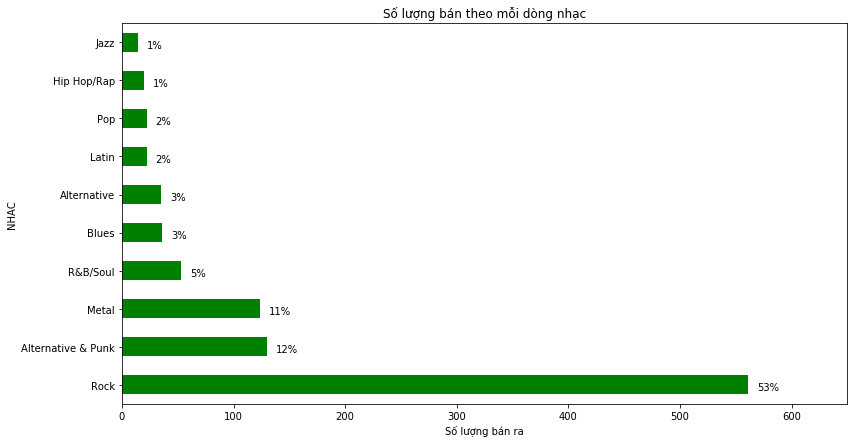

In [30]:
fig = plt.figure(figsize=(13,7))
genre_sold.SO_LUONG_BAN.plot.barh(title = 'Số lượng bán theo mỗi dòng nhạc', \
                                    xlim = (0, 650),\
                                    color = 'green', )
plt.xlabel('Số lượng bán ra')

for i, label in enumerate(list(genre_sold.index)):
    score = genre_sold.loc[label, 'SO_LUONG_BAN']
    label = (genre_sold.loc[label, 'PHAN_TRAM'] * 100).astype(int).astype(str) + '%'
    plt.annotate(str(label), (score + 8, i - 0.15))


Một điểm thú vị rút ra từ biểu đồ: <br>
Ta thấy nước Mỹ rất ưa chuộng nhạc Rock, một thể loại nhạc mà theo mình ở Việt Nam vẫn còn chưa phổ biến. Ngược lại trong khi các bài hát ở Việt Nam thường đi theo xu hướng nhạc pop thì ở Mỹ loại nhạc này lại nằm trong top bán kém chạy. <br>

Điều này chứng tỏ Thị hiếu nghe nhạc giữa nước mình và Mỹ có sự khác biệt khá rõ nét

## Câu hỏi 2: Đánh giá năng suất làm việc của các nhân viên

In [33]:
productivities = 'WITH custom_purchase AS\
                       ( \
                        SELECT c.support_rep_id,\
                              i.customer_id,\
                              SUM(i.total) total\
                        FROM customer c\
                        INNER JOIN invoice i on i.customer_id = c.customer_id\
                        group by 1,2\
                        order by 3\
                        )\
                   SELECT  \
                        e.first_name || " " || e.last_name Ten_nhan_vien,\
                        e.hire_date,\
                        sum(custom_purchase.total) Doanh_thu\
                   FROM custom_purchase\
                   INNER JOIN employee e on e.employee_id = custom_purchase.support_rep_id\
                   GROUP BY 1'

pd.read_sql(productivities, conn)
                        

,Ten_nhan_vien,hire_date,Doanh_thu
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


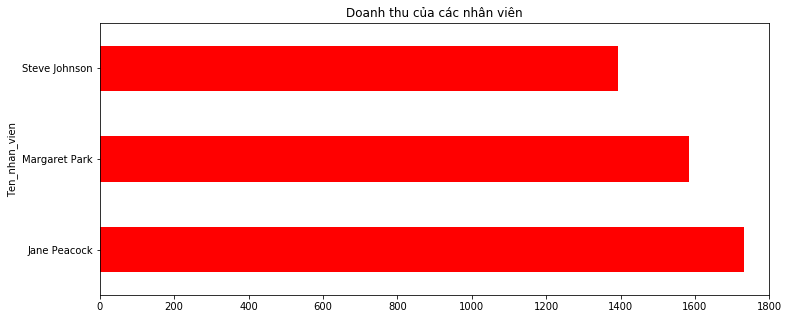

In [39]:
fig = plt.figure(figsize=(12,5))
employee_sale = pd.read_sql(productivities, conn)
employee_sale.set_index('Ten_nhan_vien', inplace=True, drop=True)
employee_sale.Doanh_thu.plot.barh(title = 'Doanh thu của các nhân viên',\
                                   xlim = (0, 1800),\
                                   color = 'red')